In [1]:
#Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from scipy import integrate

In [2]:
#File paths
this_dir = os.getcwd()
results_dir = this_dir[:-5] + 'SUMO_results/SUMO_Projects_v2p0/'

abin_file = np.loadtxt(this_dir + '/ABINCODES.txt', dtype = str, delimiter = ' ')

In [3]:
#Read in the data
spectra_150d, spectra_400d = [], []
masses = ['3p30', '4p00', '5p00', '6p00', '8p00']
mixings = ['40_60', '18_82', '10_90', '10_90', '10_90']
epochs = ['150d', '400d']

for i in range(len(masses)):
    spectrum_150d = ascii.read(results_dir + '150d/spectrum_he' + masses[i] + '_AJ_' + mixings[i] + '.datrun001')
    spectrum_400d = ascii.read(results_dir + '400d/spectrum_he' + masses[i] + '_AJ_' + mixings[i] + '.datrun001')
    spectra_150d.append(spectrum_150d)
    spectra_400d.append(spectrum_400d)
    
spectra_epochs = [spectra_150d, spectra_400d]

In [4]:
spec = spectra_150d[i]
print()

The fraction is 0.8351359486163413
The fraction is 0.8579863278791072
The fraction is 0.8948275813501784
The fraction is 0.9136879709612414
The fraction is 0.9374422999106342
The fraction is 0.9410685463781666
The fraction is 0.9452169506854144
The fraction is 0.9307981437848826
The fraction is 0.9534391115624612
The fraction is 0.97107414917659


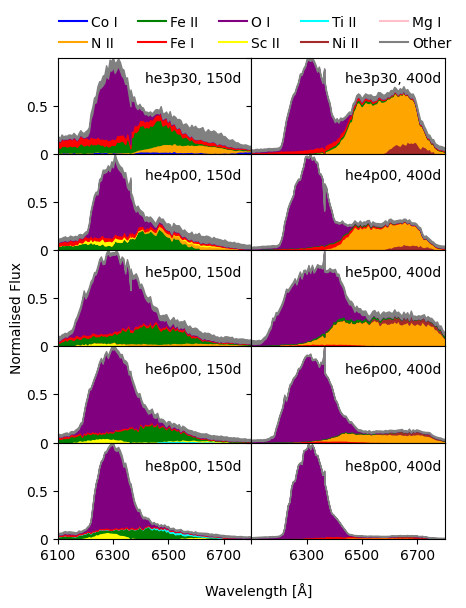

In [12]:
#Create the plot

fig, ax = plt.subplots(5, 2, figsize = (5, 6.25))
fig.subplots_adjust(hspace=0, wspace = 0)

wl_left, wl_right = 6100, 6800
n_els_to_show = 5

colours = ['blue', 'orange', 'green', 'red', 'purple', 'yellow', 'cyan', 'brown', 'pink']
els_abins = []
els_names = []

for q in range(len(spectra_epochs)):
    for i in range(len(masses)):

        spectrum = spectra_epochs[q][i]
        NII_mask = (spectrum['col1'] > wl_left) * (spectrum['col1'] < wl_right)
        spec_zoom = spectrum[NII_mask]

        top_el = np.zeros(n_els_to_show)
        top_el_indices = np.zeros(n_els_to_show)
        for j in range(145): #Lets store the 5 most important components, and their indices
            integrated_flux = integrate.cumulative_trapezoid(spec_zoom['col'+str(5+j+1)], spec_zoom['col1'])[-1] #els begin at col6
            if integrated_flux > np.min(top_el): #This is an important element!
                top_el_indices[np.argmin(top_el)] = int(j+1) #j+1 is the ABIN code
                top_el[np.argmin(top_el)] = integrated_flux 

        total_integrated_flux = integrate.cumulative_trapezoid(spec_zoom['col2'], spec_zoom['col1'])[-1]
        print('The fraction is', np.sum(top_el)/total_integrated_flux)
        #Now plot the top 5 contributions
        offset = np.zeros(len(spec_zoom))
        for k in range(n_els_to_show):
            x_data = spec_zoom['col1']
            y_data = spec_zoom['col' + str(int(top_el_indices[k])+5)]/np.max(spec_zoom['col2'])

            if top_el_indices[k] not in els_abins:
                els_abins.append(top_el_indices[k])


                els_names.append(abin_file[int(els_abins[-1]-1), 1] + ' ' + abin_file[int(els_abins[-1]-1), 2])

                #This is just to get the label in the plot
                ax[0, 0].plot(0, 0, label = els_names[-1], color = colours[int(len(els_abins)-1)])

            #ax[i, 0].plot(x_data, y_data)
            #ax[i, 0].plot(x_data, y_data + offset)
            this_el_index = els_abins.index(top_el_indices[k])
            ax[i, q].fill_between(x_data, offset, y_data + offset, color = colours[this_el_index])

            offset += y_data
            
        #Make sure to also plot the remaining flux!
        else:
            ax[i, q].fill_between(x_data, offset, spec_zoom['col2']/np.max(spec_zoom['col2']), color = 'gray')
        
        #Some plotting settings
        if q ==1:
            ax[i, q].set_yticks(ticks = [0, 0.5, 1], labels = ['', '', ''])
        elif q ==0:
            ax[i, q].set_yticks(ticks = [0, 0.5], labels = ['0', '0.5'])
            
        if i == 4 and q == 0:
            ax[i, q].set_xticks(ticks = [6100, 6300, 6500, 6700], labels = ['6100', '6300', '6500', '6700'])
        elif i == 4 and q == 1:
            ax[i, q].set_xticks(ticks = [6100, 6300, 6500, 6700], labels = ['', '6300', '6500', '6700'])
        else:
            ax[i, q].set_xticks(ticks = [0])
            
        fig.text(0.3+0.4*q, 0.84-0.155*i, s = 'he' + masses[i%len(masses)] + ', ' + epochs[q])
        
        
        ax[i, q].set_ylim(0, 1)
        ax[i, q].set_xlim(wl_left, wl_right)

#This is for the correct labels
ax[0, 0].plot(0, 0, color = 'gray', label = 'Other')



fig.text(0.03, 0.38, s = 'Normalised Flux', rotation = 90)
fig.text(0.42, 0.02, s = 'Wavelength [Å]')


plt.figlegend(bbox_to_anchor=(0.02, 0.92, 1, 0), loc= 'center',
              borderaxespad = 0, handletextpad = 0.3, ncol=5 ,columnspacing=1.5, frameon= False)

plt.savefig('Figure_x_Emitting_Ions_NII.png', dpi = 300, bbox_inches = 'tight')
plt.show()